In [ ]:
# need to reverse the order of image ids, because currently the least cloudy image is in front

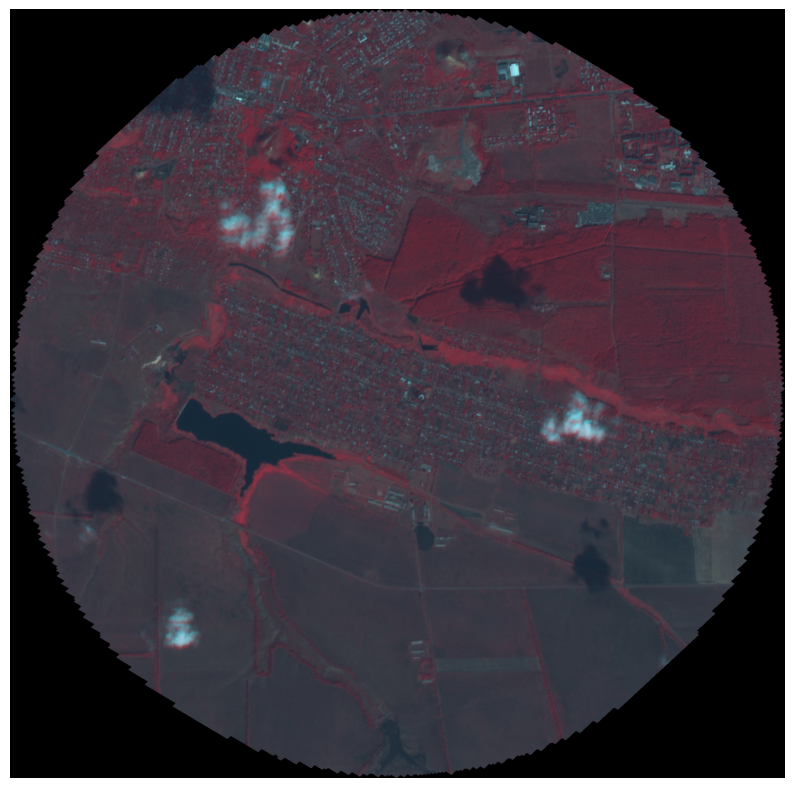

In [47]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = '/run/media/hennes/T7/projects/Seminar Paper/data/images/ae1ff67f-4e46-4eea-a00f-9c3e08de0760/composite.tif'


# Open the .tif file
with rasterio.open(IMG_DIR) as src:
    # Read the bands (assuming band 1 is infrared, band 2 is red, band 3 is green, band 4 is blue)
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)
    infrared = src.read(4)

    # Stack the bands into a single array
    img = np.stack((infrared, red, green), axis=-1)

    # Normalize the image data to 0-1 range for display
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [19]:
from datetime import datetime
import pandas as pd

import getpass
from planet import Auth, Session
from planet import order_request
from planet_helpers import parse_polygon, load_search_files, main_order

import asyncio
import nest_asyncio
nest_asyncio.apply()

from tqdm.asyncio import tqdm  # Use tqdm.asyncio for async support

# initialise logging
import logging
logging.basicConfig(
    filename='../download_images.log',  # Log file location
    level=logging.ERROR,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s'  # Log message format
)

DATA_DIR = "../data"
DOWNLOAD_DIR = DATA_DIR + "/images"
SEARCH_DIR = DATA_DIR + "/searches"

In [2]:
user = input("Username: ")
pw = getpass.getpass()
auth = Auth.from_login(user,pw)
auth.store()

In [20]:
sample_df = pd.read_csv(DATA_DIR + "/download_sample.csv")
places_df = pd.read_csv(DATA_DIR + "/places.csv")[["location_id", "geometry"]]

# merge both dfs on location_id
sample_df = sample_df.merge(places_df, on="location_id")

In [21]:
sample_df["after_image_id"] = sample_df["after_image_id"].str.strip("[]").str.replace("'", "").str.split(", ")
sample_df["before_image_id"] = sample_df["before_image_id"].str.strip("[]").str.replace("'", "").str.split(", ")

100%|██████████| 20/20 [04:51<00:00, 14.56s/it]


In [5]:
index = i
name = sample_df.loc[index, "search_id"] + "_after"
before_item_ids = sample_df.loc[index, "before_image_id"]
before_item_ids.reverse()
after_item_ids = sample_df.loc[index, "after_image_id"]
after_item_ids.reverse()
all_item_ids = [before_item_ids, after_item_ids]
coords = parse_polygon(sample_df.loc[index, "geometry"])
geom = {
         "type": "Polygon",
         "coordinates": coords
      }


before_order_dict = {
    "name" : sample_df.loc[index, "search_id"] + "_before",
    "item_ids" : before_item_ids,
    "geom": geom
    }

after_order_dict = {
   "name" : sample_df.loc[index, "search_id"] + "_after",
   "item_ids" : after_item_ids,
   "geom": geom
   }

order_list

In [25]:
sample_df.head(20).tail(10)

,search_id,before_image_id,after_image_id,location_id,geometry
10,events_1048757,"[20180919_075516_1013, 20180919_075517_1013]","[20180924_075646_0f28, 20180924_075647_0f28]",1733,"POLYGON ((37.93447 48.24827, 37.93411 48.24805..."
11,events_1052668,[20180919_105739_0f06],"[20180924_075322_103b, 20180924_075529_0f17, 2...",1678,"POLYGON ((38.44036 48.63063, 38.44078 48.63047..."
12,events_1053783,"[20180922_075341_1005, 20180922_075342_1005, 2...","[20180924_075322_103b, 20180924_071631_1048, 2...",2793,"POLYGON ((38.73909 48.64329, 38.73927 48.6434,..."
13,events_1059817,"[20180924_075324_103b, 20180924_075323_103b]","[20180928_075410_103c, 20180928_075409_103c, 2...",895,"POLYGON ((38.4993 48.59089, 38.49909 48.59097,..."
14,events_1060575,"[20180922_075443_1024, 20180922_075623_103e, 2...","[20180928_072015_0f1a, 20180928_072016_0f1a]",1653,"POLYGON ((37.8206 48.12641, 37.82039 48.12649,..."
15,events_1061979,"[20180922_075626_103e, 20180922_075625_103e]","[20180928_072014_0f1a, 20180928_075746_0f43, 2...",3057,"POLYGON ((37.54647 47.98538, 37.54668 47.9853,..."
16,events_1061737,"[20180922_075440_1024, 20180922_075439_1024]","[20180927_075609_1038, 20180927_075427_1027]",2815,"POLYGON ((37.91086 48.32602, 37.91128 48.32585..."
17,events_1063733,"[20180924_075322_103b, 20180924_075323_103b, 2...",[20180928_075409_103c],845,"POLYGON ((38.59014 48.57169, 38.59032 48.5718,..."
18,events_1067383,"[20180922_075449_1024, 20180922_075448_1024, 2...",[20181001_075655_1011],529,"POLYGON ((37.67339 47.72225, 37.67356 47.72236..."
19,events_1068742,"[20180922_075458_1024, 20180922_075457_1024, 2...","[20180928_075550_101b, 20180928_075551_101b]",1888,"POLYGON ((37.8157 47.17976, 37.81505 47.17935,..."


In [26]:
async def process_download(DOWNLOAD_DIR, search, cl, pbar, semaphore):
    async with semaphore:
        try:
            await main_order(DOWNLOAD_DIR, search, cl)
            
        except Exception as e:
            logging.error(f"processing search {search['name']}: {e}")
        finally:
            pbar.update(1)

async def main():
    DOWNLOAD_DIR = DATA_DIR + "/images"

    sample_df = pd.read_csv(DATA_DIR + "/download_sample.csv")
    places_df = pd.read_csv(DATA_DIR + "/places.csv")[["location_id", "geometry"]]

    # merge both dfs on location_id
    sample_df = sample_df.merge(places_df, on="location_id")

    sample_df["after_image_id"] = sample_df["after_image_id"].str.strip("[]").str.replace("'", "").str.split(", ")
    sample_df["before_image_id"] = sample_df["before_image_id"].str.strip("[]").str.replace("'", "").str.split(", ")

    order_list = []

    # iterate over rows of df
    for index, row in sample_df.head(20).tail(10).iterrows():
        before_item_ids = row["before_image_id"]
        before_item_ids.reverse()
        after_item_ids = row["after_image_id"]
        after_item_ids.reverse()
        coords = parse_polygon(row["geometry"])
        geom = {
            "type": "Polygon",
            "coordinates": coords
        }

        before_order_dict = {
            "name" : row["search_id"] + "_before",
            "item_ids" : before_item_ids,
            "geom": geom
        }

        after_order_dict = {
            "name" : row["search_id"] + "_after",
            "item_ids" : after_item_ids,
            "geom": geom
        }

        order_list.append(before_order_dict)
        order_list.append(after_order_dict)

    
    semaphore = asyncio.Semaphore(100)  # Limit concurrency to 10
    async with Session() as sess:
        cl = sess.client('orders')

        pbar = tqdm(total=len(order_list), smoothing=0.05)
        await asyncio.gather(*(process_download(DOWNLOAD_DIR, search, cl, pbar, semaphore) for search in order_list))
        pbar.close()

In [27]:
asyncio.run(main())































































































































































































00:00 - order  - state: creatingA
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:01 - order  - state: creating




















































































00:02 - order  - state: creatingA





































































































00:03 - order  - state: creatingA








































































































































































































































































































































































In [11]:
async with Session() as sess:
    cl = sess.client('orders')
    orders = orders_list = [o async for o in cl.list_orders()]
